# 1D Normal distribution

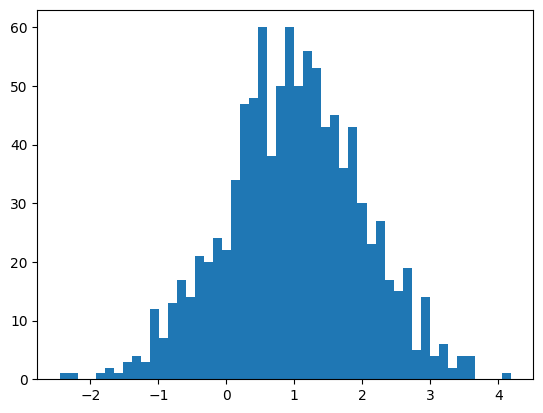

In [310]:
import torch
import matplotlib.pyplot as plt

# Generate data
n_samples = 1000
true_mean = 1
true_std = 1

def normal_distribution(mean, std):
    return torch.distributions.Normal(mean, std)

dist = normal_distribution(true_mean, true_std)
data = dist.sample((n_samples,))

# Plot the data
plt.hist(data, bins=50)
plt.show()



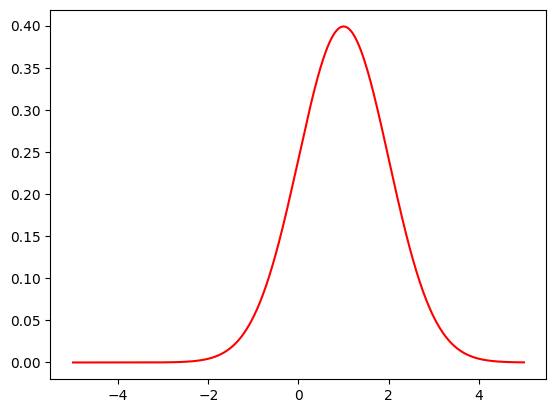

In [311]:
def plot_distribution(dist, x=None):
    if x is None:
        x = torch.linspace(-5, 5, 1000)
    plt.plot(x, dist.log_prob(x).exp(), 'r')
    plt.show()

plot_distribution(dist)

In [312]:
# Calculate the laplace approximation

# Calculate the mode of the distribution

def mode_dist(dist, x):
    # calculate the mode of the distribution
    mode_idx = torch.argmax(dist.log_prob(x).exp())
    return x[mode_idx].item()

x = torch.linspace(-5, 5, 1000)
mode = round(mode_dist(dist,x),3)
mode

0.996

In [313]:
def second_derivative_dist(dist, mode):
    # using torch.autograd.grad to calculate the second derivative of the distribution at the mode 
    # (i.e. the curvature of the distribution at the mode)
    x = torch.tensor(mode, requires_grad=True)
    y = dist.log_prob(x)
    grad = torch.autograd.grad(y, x, create_graph=True)[0]
    grad2 = torch.autograd.grad(grad, x)[0]
    return grad2

# second_derivative_dist(dist,mode)

In [314]:
# Calculate the standard deviation of the distribution

def scale_laplace(dist, mode):
    hessian = second_derivative_dist(dist, mode)
    return torch.sqrt(-1/hessian)

# scale_laplace(mode)

In [315]:
def laplace_approx_dist(dist, mode):
    # print(mode)
    scale = scale_laplace(dist, mode)
    # print("The scale in laplace_approx_dist is ",scale)
    laplace_dist = normal_distribution(mode, scale)
    return laplace_dist

# laplace_dist = laplace_approx_dist(dist, mode)

def plot_normal_laplace_distributions(dist, laplace_dist, x=None):
    # laplace_dist = laplace_approx_dist(dist, mode)
    if x is None:
        x = torch.linspace(-5, 5, 1000)
    plt.plot(x, dist.log_prob(x).exp(), 'r')
    plt.plot(x, laplace_dist.log_prob(x).exp(), 'b', linestyle='--')
    plt.show()

# plot_normal_laplace_distributions(dist)

In [316]:
from ipywidgets import interact

def interactive_plots_normal_laplace(true_mean, true_std):
    dist = normal_distribution(true_mean, true_std)
    x = torch.linspace(-5, 5, 1000)
    mode = round(mode_dist(dist,x),3)
    # print(mode)
    laplace_dist = laplace_approx_dist(dist, mode)
    plot_normal_laplace_distributions(dist, laplace_dist)

# interactive_plots_normal_laplace(true_mean=-1, true_std=1)

In [317]:
interact(interactive_plots_normal_laplace, true_mean=(-5,5,0.1), true_std=(0.1,5,0.1))

interactive(children=(FloatSlider(value=0.0, description='true_mean', max=5.0, min=-5.0), FloatSlider(value=2.…

<function __main__.interactive_plots_normal_laplace(true_mean, true_std)>

# 2D Normal distribution

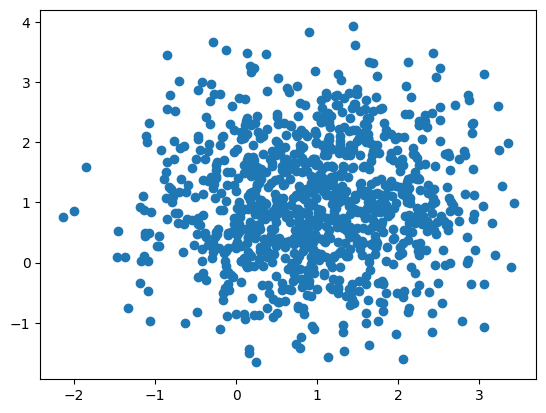

In [318]:
true_mean = torch.tensor([1.,1.])
true_cov = torch.tensor([[1.,0.],[0.,1.]])

def multivariate_normal_distribution(mean, cov):
    return torch.distributions.MultivariateNormal(mean, cov)

dist = multivariate_normal_distribution(true_mean, true_cov)
data = dist.sample((n_samples,))

# Plot the data
plt.scatter(data[:,0], data[:,1])
plt.show()

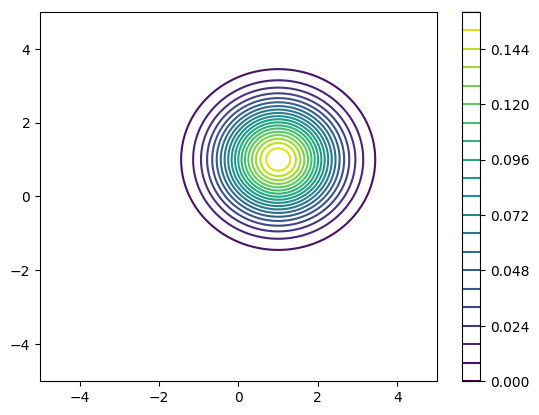

In [319]:
# Plot contour plot of the distribution
def plot_contour_dist(dist, colour=None, alpha=None, linestyle=None, x=None, y=None):
    if x is None:
        x = torch.linspace(-5, 5, 1000)
    if y is None:
        y = torch.linspace(-5, 5, 1000)
    X, Y = torch.meshgrid(x, y)
    Z = torch.stack([X, Y], dim=-1)
    z = dist.log_prob(Z).exp()
    z = z.detach().numpy()
    if colour is None:
        colour = 'viridis'
    if alpha is None:
        alpha = 1
    if linestyle is None:
        linestyle = 'solid'
    plt.contour(X, Y, z , levels = 20, cmap = colour, alpha = alpha, linestyles = linestyle)
    plt.colorbar()
    # plt.show()

plot_contour_dist(dist)
plt.show()

In [320]:
# Apply gradient descent to get the mode of the distribution
def mode_loss_fn(params, dist):
    new_mean = params
    # new_cov = torch.tensor([[params[2], params[3]], [params[3], params[4]]])
    # new_dist = multivariate_normal_distribution(new_mean, new_cov)
    return -dist.log_prob(new_mean).sum()
    # return -dist.log_prob(theta).exp()
    # return -dist.log_prob(torch.stack([x,y], dim=-1)).exp()

def mode_gradient_descent(dist, params, lr=0.1, epochs=1000):
    # theta.requires_grad_(True)
    optimizer = torch.optim.Adam([params], lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = mode_loss_fn(params, dist)
        loss.backward()
        optimizer.step()
    return params

params_init = torch.tensor([0.0, 0.0], requires_grad=True)
params_mode = mode_gradient_descent(dist, params_init)
params_mode

tensor([1., 1.], requires_grad=True)

In [321]:
def hessian_bivariate_normal(dist, mode):
    hessian = torch.autograd.functional.hessian(dist.log_prob, mode)
    return torch.inverse(-hessian)

hessian_bivariate_normal(dist, params_mode)

tensor([[1., 0.],
        [0., 1.]])

In [322]:
def laplace_approx_bivariate_normal(dist, mode):
    scale = hessian_bivariate_normal(dist, mode)
    # print("The scale in laplace_approx_bivariate_normal is ",scale)
    laplace_dist = multivariate_normal_distribution(mode, scale)
    return laplace_dist

def plot_bivariate_normal_laplace(mean1, mean2, cov11, cov12, cov22):
    true_mean = torch.tensor([mean1, mean2])
    true_cov = torch.tensor([[cov11, cov12], [cov12, cov22]])
    dist = multivariate_normal_distribution(true_mean, true_cov)
    params_init = torch.tensor([0.0, 0.0], requires_grad=True)
    params_mode = mode_gradient_descent(dist, params_init)
    print(params_mode)
    laplace_dist = laplace_approx_bivariate_normal(dist, params_mode)
    plot_contour_dist(dist, colour='Reds')
    plot_contour_dist(laplace_dist, colour='plasma', linestyle='--')
    plt.show()

In [329]:
interact(plot_bivariate_normal_laplace, mean1=(-5,5,0.1), mean2=(-5,5,0.1), cov11=(0.1,5,0.1), cov12=(-5,5,0.1), cov22=(0.1,5,0.1))

interactive(children=(FloatSlider(value=0.0, description='mean1', max=5.0, min=-5.0), FloatSlider(value=0.0, d…

<function __main__.plot_bivariate_normal_laplace(mean1, mean2, cov11, cov12, cov22)>

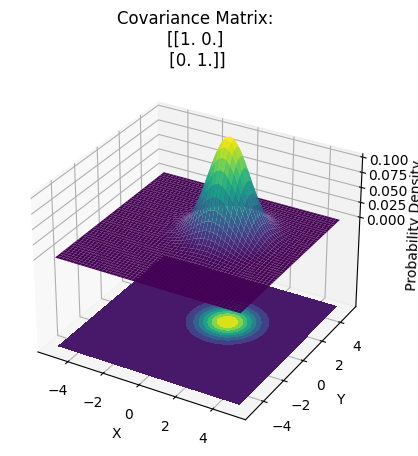

In [324]:
# Plot 3d prior
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

x_range = torch.linspace(-5, 5, 1000)
y_range = torch.linspace(-5, 5, 1000)
X, Y = np.meshgrid(x_range, y_range)
grid = np.column_stack((X.flatten(), Y.flatten()))

pdf_values = multivariate_normal.pdf(grid, true_mean, true_cov)
pdf_values = pdf_values.reshape(X.shape)
# laplace_pdf_values = multivariate_normal.pdf(grid, params_mode.detach().numpy(), hessian_bivariate_normal(dist, params_mode).detach().numpy())
# laplace_pdf_values = laplace_pdf_values.reshape(X.shape)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, pdf_values, cmap='viridis')
cset = ax.contourf(X, Y, pdf_values, zdir='z', offset=-0.15, cmap='viridis')
# cset_laplace = ax.contourf(X, Y, laplace_pdf_values, zdir='z', offset=-0.15, cmap='plasma')
ax.set_zlim(-0.15, 0.1)
ax.set_zticks(np.linspace(0, 0.1, 5))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Probability Density')
ax.set_title(f'Covariance Matrix:\n{true_cov.numpy()}')
# plt.savefig('figures/mle/bivariate_normal.pdf')
plt.show()

# Beta distribution

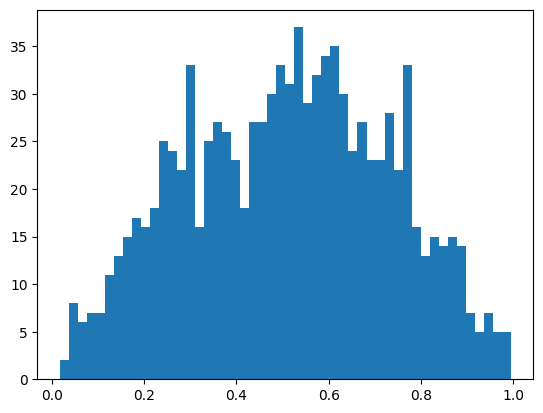

In [325]:
alpha = 2
beta = 2

def beta_distribution(alpha, beta):
    return torch.distributions.Beta(alpha, beta)

dist = beta_distribution(alpha, beta)
data = dist.sample((n_samples,))

# Plot the data
plt.hist(data, bins=50)
plt.show()

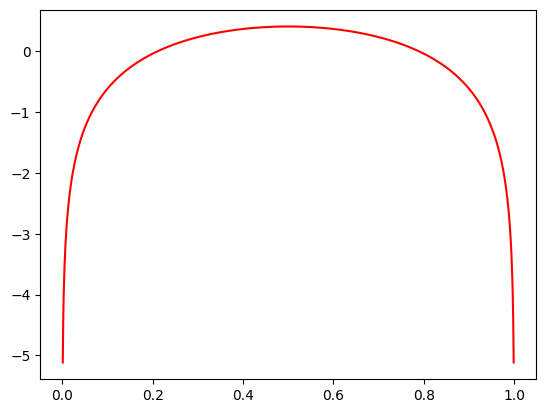

In [330]:
# Plot pdf of the distribution

def plot_beta_dist(dist, x=None):
    if x is None:
        x = torch.linspace(0, 1, 1000)
    plt.plot(x, dist.log_prob(x), 'r')
    plt.show()

plot_beta_dist(dist)

In [331]:
x = torch.linspace(0, 1, 1000)
mode_beta = mode_dist(dist, x)
mode_beta


0.49949949979782104

In [332]:
def interactive_plots_beta_laplace(alpha, beta):
    dist = beta_distribution(alpha, beta)
    x = torch.linspace(0, 1, 1000)
    mode = round(mode_dist(dist,x),3)
    # print(mode)
    laplace_dist = laplace_approx_dist(dist, mode)
    plot_normal_laplace_distributions(dist, laplace_dist, x=x)

# interactive_plots_beta_laplace(alpha=2, beta=2)
interact(interactive_plots_beta_laplace, alpha=(2,10,1), beta=(2,10,1))

interactive(children=(IntSlider(value=6, description='alpha', max=10, min=2), IntSlider(value=6, description='…

<function __main__.interactive_plots_beta_laplace(alpha, beta)>